In [17]:
import json
import cv2
import os

os.environ["CUDA_VISIBLE_DEVICES"]="3"
import matplotlib.pyplot as plt
import numpy as np
from pycocotools import mask as maskUtils
segmentation_json = "/home/datadisk/evaluation/results/florence_ours/S7-update/[PIX_SEG]iSAID_Annotations_s.json"

# Load the JSON file
with open(segmentation_json, 'r') as f:
    json_data = json.load(f)

data = json_data['data']


In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    return mask_image

def show_mask2(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    
    mask_image = mask * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    return mask_image

def show_mask3(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    
    mask_image = mask * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    return mask_image
    
    
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  


def polygon_to_mask(polygon, image_height, image_width):
    # Create an empty mask
    mask = np.zeros((image_height, image_width), dtype=np.uint8)
    
    # Create a COCO-style RLE (Run-Length Encoding) mask from polygon
    rle = maskUtils.frPyObjects(polygon, image_height, image_width)
    
    # Decode the RLE mask to binary mask
    mask = maskUtils.decode(rle)
    
    return mask

def dice_coefficient(mask1, mask2):
    mask1 = mask1>0
    mask2 = mask2>0
    
    # Ensure masks are binary and have the same shape
    mask1 = np.asarray(mask1, dtype=np.bool_)
    mask2 = np.asarray(mask2, dtype=np.bool_)

    intersection = np.logical_and(mask1, mask2).sum()
    
    union = np.logical_or(mask1, mask2).sum()
    
    # Compute Dice coefficient
    dice = 2. * intersection / (intersection+union)  # Handle case where union is 0
    return dice

def get_mask_segment(image, binary_mask):
    mask_bool = binary_mask.squeeze() == 1  # Now mask_bool has shape (w, h)
    
    # Expand mask_bool along the third dimension to match the RGB image shape
    mask_bool_3d = np.stack([mask_bool] * 3, axis=-1)  # Now mask_bool_3d has shape (w, h, 3)
    
    
    # Get the coordinates of the bounding box around the non-zero (True) regions
    coords = np.argwhere(mask_bool)
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0) + 1  # Add 1 to include the boundary
    
    # Crop the original image to this bounding box
    cropped_image = image[y_min:y_max, x_min:x_max]
    
    # Optional: Apply mask within the cropped area if you only want masked pixels in the crop
    cropped_masked_image = np.zeros_like(cropped_image)
    cropped_mask = mask_bool[y_min:y_max, x_min:x_max]
    cropped_masked_image[cropped_mask] = cropped_image[cropped_mask]
    return cropped_masked_image

In [60]:
import open_clip
import torch
from PIL import Image

def val_clip(model, tokenizer, preprocess, image_list, text_queries, datadisk = '/home/datadisk/evaluation/data/Benchmark/datasets/'):
    ##temp work
    model = model
    model = model.eval()
    model.to('cuda')
    tokenizer = tokenizer
    preprocess = preprocess
    text = tokenizer(text_queries)
    result_list = []
    with torch.no_grad(), torch.cuda.amp.autocast():
        for data in image_list:
            cropped_pil_image = Image.fromarray(data)
            image = preprocess(cropped_pil_image).unsqueeze(0)
            image_features = model.encode_image(image.cuda())
            text_features = model.encode_text(text.cuda())
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
        
            text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1).cpu().numpy()[0]
            
            #print(f'Predictions of {model_name} for image {i} :')
            zipped = zip(text_queries, text_probs)
            zipped = list(zipped)
            res = sorted(zipped, key = lambda x: x[1],reverse=True)
            result_list.append(res)

    return result_list
    
def CLIP_with_weight(model_name, model_weight):
    if model_weight == "":
        model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained='openai')
    elif 'skyclip' in model_weight:
        model, _, preprocess = open_clip.create_model_and_transforms(
            model_name,
            model_weight,
            output_dict=True,
            force_quick_gelu=True,
        )
    else:
        model, _, preprocess = open_clip.create_model_and_transforms(model_name)
        ckpt = torch.load(model_weight, map_location="cpu")
        message = model.load_state_dict(ckpt)
    
    
    tokenizer = open_clip.get_tokenizer(model_name)
    return model, preprocess, tokenizer

def val_classification(clip_type,
                       weight_file,
                       input_image,
                       class_list,
                       CLIP_model_name = 'ViT-B-32', 
            ):
    #clip model
    CLIP_model_name =  CLIP_model_name
    CLIP_model_weight = weight_file
    remode_clip_model, remode_clip_preprocess, remode_clip_tokenizer = CLIP_with_weight(CLIP_model_name, CLIP_model_weight)

    #dataset
    class_label = class_list#{'harbor', 'non-harbor'}#{'road', 'building', 'forest', 'sea','area of building', 'cropland','tennis court', 'soccer ball field', 'vehicle', 'harbor'}
    text_queries = [f"a photo of a {label}" for label in class_label]
    
    #result
    result_list = val_clip(remode_clip_model, remode_clip_tokenizer, remode_clip_preprocess, [input_image], text_queries)
    return result_list



Segment out vehicle in the image.
448 448


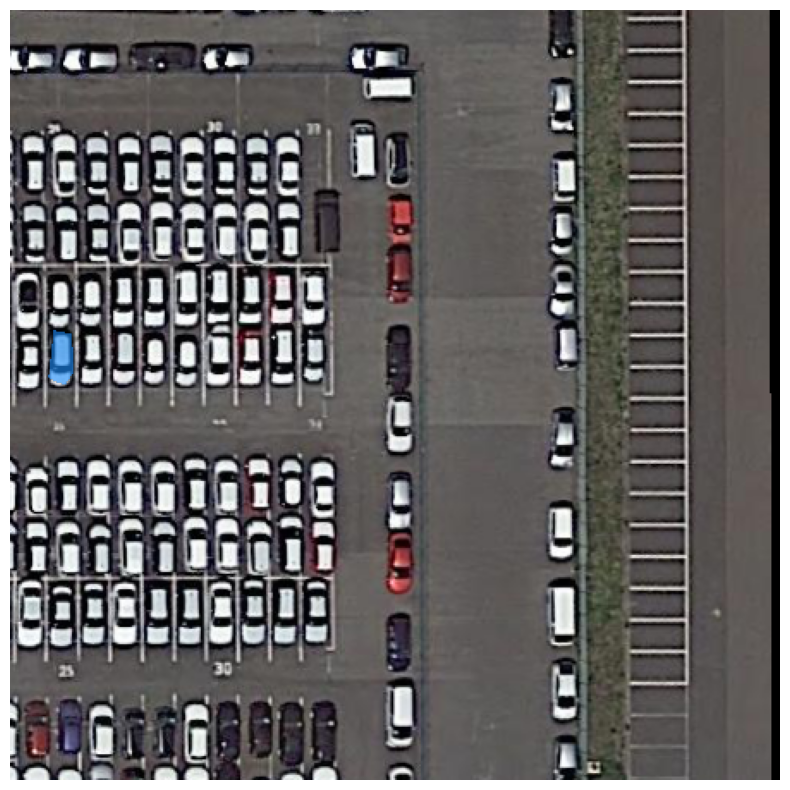

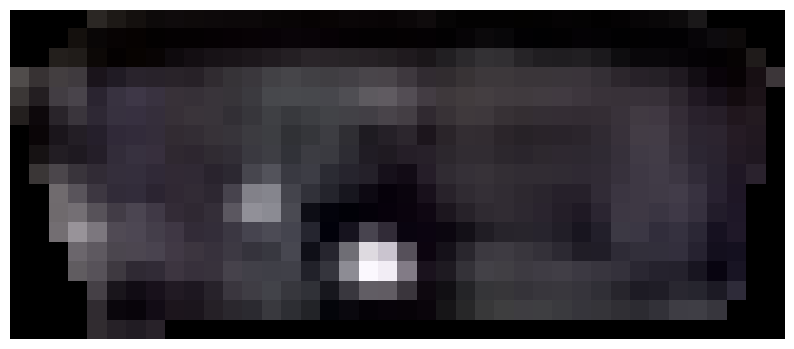

GT [[('a photo of a non-car', 0.6992544), ('a photo of a car', 0.30074558)]]
ANS [[('a photo of a non-car', 0.6757646), ('a photo of a car', 0.32423538)]]


In [104]:
index = 50
object_index = 1
class_list = {'car', 'non-car'}

image_file = data[index]['image']

try:
    image = cv2.imread(os.path.join("/home/oss/Datasets/", image_file))
except:
    new_root_path = '/home/datadisk2/Datasets2/processed_datasets/'
    image = cv2.imread(os.path.join(new_root_path, image_file))

image_source = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
crop = data[index]['crop']
question_fjson = data[index]['question']
print (question_fjson)
cropped_image = image_source[crop[1]:crop[3], crop[0]:crop[2]]
H, W, _ = cropped_image.shape
print (H, W)
binary_mask_gt = polygon_to_mask(data[index]['gt'][object_index], H, W)
binary_mask_ans = polygon_to_mask(data[index]['answer'][object_index], H, W)


plt.figure(figsize=(10, 10))
plt.imshow(cropped_image)
show_mask2(binary_mask_gt, plt.gca())
plt.axis('off')
plt.show()


cropped_masked_image_gt = get_mask_segment(cropped_image, binary_mask_gt)
cropped_masked_image_ans = get_mask_segment(cropped_image, binary_mask_ans)
plt.figure(figsize=(10, 10))
plt.imshow(cropped_masked_image_ans)
plt.axis('off')
plt.show()

Clip_model_name = 'ViT-L-14'
remoteClip_weight = f"/home/datadisk/pipe/model/RemoteCLIP-{Clip_model_name}.pt"

#GT
result_list = val_classification("NA", remoteClip_weight, cropped_masked_image_gt, class_list, CLIP_model_name=Clip_model_name)
print ('GT', result_list)


result_list = val_classification("NA", remoteClip_weight, cropped_masked_image_ans, class_list, CLIP_model_name=Clip_model_name)
print ('ANS', result_list)

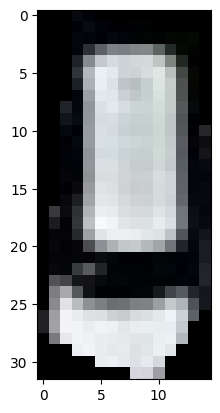

In [105]:
plt.imshow(cropped_masked_image_gt)

{'image': 'GID15/GID/img_dir/val/GF2_PMS1__L1A0001064454-MSS1.tif',
 'crop': [403, 1209, 851, 1657],
 'question': 'Segment out road in the image.',
 'answer': [[[63.84000015258789,
    0.2240000069141388,
    0.2240000069141388,
    109.53600311279297,
    0.2240000069141388,
    130.59201049804688,
    75.93600463867188,
    0.2240000069141388]]],
 'gt': [[[61.152000427246094,
    0.2240000069141388,
    0.2240000069141388,
    105.5040054321289,
    0.2240000069141388,
    133.27999877929688,
    79.07200622558594,
    0.2240000069141388]]]}

(448, 448, 1)